# Maximum Entropy Inverse Reinforcement Learning

The code in this notebook is based on the Maximum Entropy Inverse Reinforcement Learning paper by Ziebart et al. (2008).

## Introduction

Inverse reinforcement learning (IRL) ... TODO

The general idea of Maximum Entropy Inverse Reinforcement Learning is based on feature-expectation matching.

TODO: introduction, general idea

### Notes Regarding the Code in this Notebook

The code provided in this notebook is written for readability.
In some sections, this has a considerable impact on performance, as many operations, especially the ones involving the transition probability $P(s_k \mid s_i, a_j)$, can be reformulated as a combination or series of matrix multiplications. For an implementation considering these optimizations have a look at the accompanying python files. 

## Preparation

TODO

In [1]:
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../src')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
import gridworld as W    # basic grid-world MDPs
import trajectory as T   # trajectory generation
import optimizer as O    # stochastic gradient descent optimizer
import solver as S       # MDP solver (value-iteration)
import plot as P         # helper-functions for plotting

In [4]:
%matplotlib notebook
style = {
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [5]:
def setup_mdp():
    # create our world
    world = W.IcyGridWorld(size=5, p_slip=0.2)

    # set up the reward function
    reward = np.zeros(world.n_states)
    reward[-1] = 1.0
    reward[8] = 0.65

    # set up terminal states
    terminal = [24]

    return world, reward, terminal

# set-up the GridWorld Markov Decision Process
world, reward, terminal = setup_mdp()

In [6]:
def generate_expert_trajectories(world, reward, terminal):
    n_trajectories = 200         # the number of "expert" trajectories
    discount = 0.9               # discount for constructing an "expert" policy
    weighting = lambda x: x**50  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value = S.value_iteration(world.p_transition, reward, discount)
    
    # create our stochastic policy using the value function
    policy = S.stochastic_policy_from_value(world, value, w=weighting)
    
    # a function that executes our stochastic policy by choosing actions according to it
    policy_exec = T.stochastic_policy_adapter(policy)
    
    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))
    
    return tjs, policy

# generate some "expert" trajectories (and its policy for visualization)
trajectories, expert_policy = generate_expert_trajectories(world, reward, terminal)

<IPython.core.display.Javascript object>


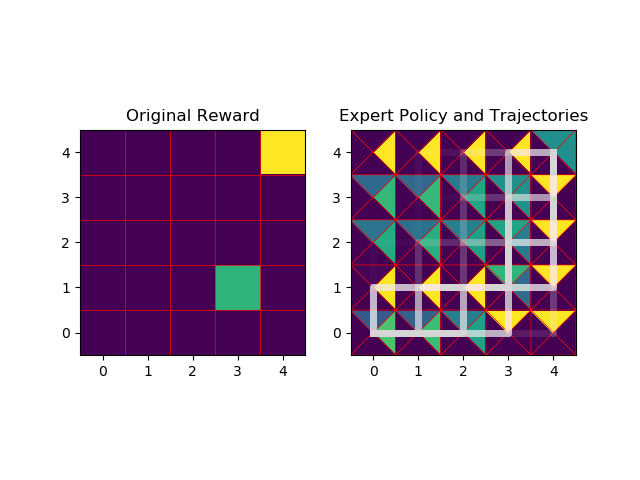

In [7]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
P.plot_state_values(ax, world, reward, **style)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
P.plot_stochastic_policy(ax, world, expert_policy, **style)

for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)

plt.show()

In [8]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:
        for s in t.states():
            fe += features[s, :]

    return fe / len(trajectories)

In [9]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0

    return p / len(trajectories)

In [10]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states
    
    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states)                             # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions))            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
        
        # sum over all actions
        zs = za.sum(axis=1)

    # 3. compute local action probabilities
    p_action = za / zs[:, None]

    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states
        
        # for all states
        for s_to in range(n_states):
            
            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

In [11]:
def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    
    # compute starting-state probabilities from trajectories
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # gradient descent optimization
    theta = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    optim.reset(theta)              # re-start optimizer
    while delta > eps:              # iterate until convergence
        theta_old = theta.copy()

        # compute per-state reward from features
        reward = features.dot(theta)

        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        
        # re-compute detla for convergence check
        delta = np.max(np.abs(theta_old - theta))

    # re-compute per-state reward and return
    return features.dot(theta)

In [12]:
# set up features: we use one feature vector per state
features = W.state_features(world)

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# actually do some inverse reinforcement learning
reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories, optim, init)

<IPython.core.display.Javascript object>


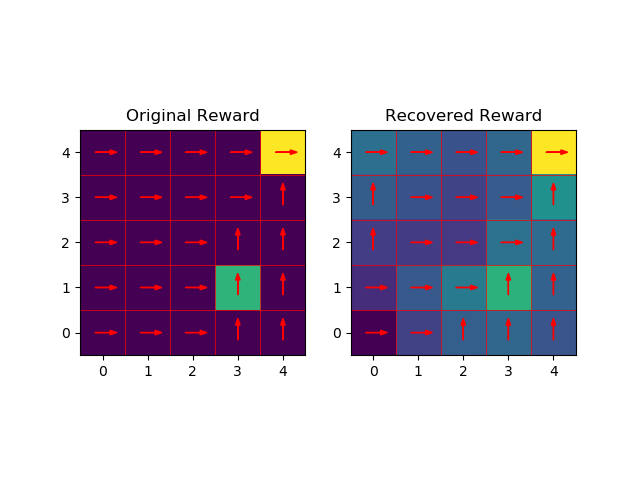

In [13]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
P.plot_state_values(ax, world, reward, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward, 0.8), color='red')

ax = fig.add_subplot(122)
ax.title.set_text('Recovered Reward')
P.plot_state_values(ax, world, reward_maxent, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.8), color='red')

plt.show()

<IPython.core.display.Javascript object>


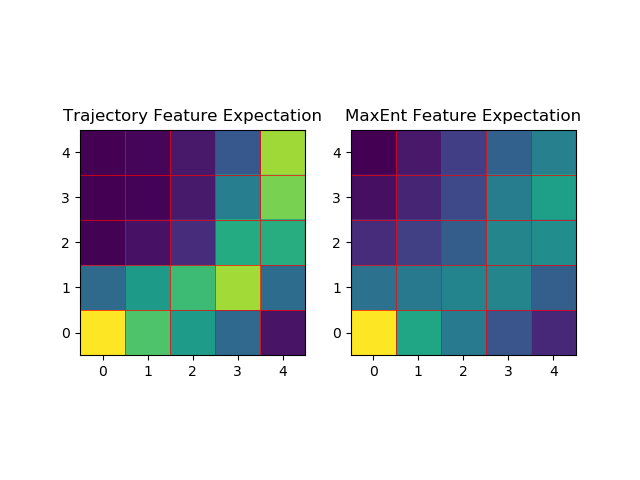

In [14]:
p_initial = initial_probabilities_from_trajectories(world.n_states, trajectories)
e_svf = compute_expected_svf(world.p_transition, p_initial, terminal, reward_maxent)
e_features = feature_expectation_from_trajectories(features, trajectories)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Trajectory Feature Expectation')
P.plot_state_values(ax, world, e_features, **style)

ax = fig.add_subplot(122)
ax.title.set_text('MaxEnt Feature Expectation')
P.plot_state_values(ax, world, features.T.dot(e_svf), **style)

plt.show()